In [1]:
import pandas as pd
import numpy as np

In [2]:
calls_df = pd.read_csv('callsf0d4f5a.csv')
customers_df = pd.read_csv('customers2afd6ea.csv')
reason_df = pd.read_csv('reason18315ff.csv')
sentiment_df = pd.read_csv('sentiment_statisticscc1e57a.csv')

In [3]:
print(calls_df.head())
print(customers_df.head())
print(reason_df.head())
print(sentiment_df.head())

      call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118     7/31/2024 23:56   
1  1122072124   8186702651    519057       8/1/2024 0:03   
2  6834291559   2416856629    158319     7/31/2024 23:59   
3  2266439882   1154544516    488324       8/1/2024 0:05   
4  1211603231   5214456437    721730       8/1/2024 0:04   

  agent_assigned_datetime call_end_datetime  \
0           8/1/2024 0:03     8/1/2024 0:34   
1           8/1/2024 0:06     8/1/2024 0:18   
2           8/1/2024 0:07     8/1/2024 0:26   
3           8/1/2024 0:10     8/1/2024 0:17   
4           8/1/2024 0:14     8/1/2024 0:23   

                                     call_transcript  
0  \n\nAgent: Thank you for calling United Airlin...  
1  \n\nAgent: Thank you for calling United Airlin...  
2  \n\nAgent: Thank you for calling United Airlin...  
3  \n\nAgent: Thank you for calling United Airlin...  
4  \n\nAgent: Thank you for calling United Airlin...  
   customer_id      custom

In [4]:
customers_df['elite_level_code'] = customers_df['elite_level_code'].fillna('NaN')
customers_df.to_csv('customers.csv', index=False)

sentiment_df['agent_tone'] = sentiment_df['agent_tone'].fillna('neutral')

sentiment_df = sentiment_df.dropna(subset=['average_sentiment'])


sentiment_df.to_csv('sentiment.csv', index=False)


calls_df['call_start_datetime'] = pd.to_datetime(calls_df['call_start_datetime'])
calls_df['agent_assigned_datetime'] = pd.to_datetime(calls_df['agent_assigned_datetime'])
calls_df['call_end_datetime'] = pd.to_datetime(calls_df['call_end_datetime'])

calls_df['AHT_inSeconds'] = (calls_df['call_end_datetime'] - calls_df['agent_assigned_datetime']).dt.total_seconds()
calls_df['AST_inSeconds'] = (calls_df['agent_assigned_datetime'] - calls_df['call_start_datetime']).dt.total_seconds()



merged_df = pd.merge(calls_df, reason_df, on='call_id', how='left')


merged_df = pd.merge(merged_df, sentiment_df, on='call_id', how='left')


merged_df = pd.merge(merged_df, customers_df, on='customer_id', how='left')

merged_df.dropna()

print(merged_df)

          call_id  customer_id  agent_id_x call_start_datetime  \
0      4667960400   2033123310      963118 2024-07-31 23:56:00   
1      1122072124   8186702651      519057 2024-08-01 00:03:00   
2      6834291559   2416856629      158319 2024-07-31 23:59:00   
3      2266439882   1154544516      488324 2024-08-01 00:05:00   
4      1211603231   5214456437      721730 2024-08-01 00:04:00   
...           ...          ...         ...                 ...   
71805  1563273072   8022667294      413148 2024-08-31 23:48:00   
71806  8865997781   4474867021      980156 2024-08-31 23:55:00   
71807  8019240181   9762042472      616988 2024-08-31 23:52:00   
71808  8332067080   8095620266      161354 2024-08-31 23:53:00   
71809  8210720833   8014388758      547592 2024-08-31 23:49:00   

      agent_assigned_datetime   call_end_datetime  \
0         2024-08-01 00:03:00 2024-08-01 00:34:00   
1         2024-08-01 00:06:00 2024-08-01 00:18:00   
2         2024-08-01 00:07:00 2024-08-01 00:26:0

In [5]:
avg_aht = merged_df['AHT_inSeconds'].mean()
avg_ast = merged_df['AST_inSeconds'].mean()
print(f"Overall Average Handle Time (AHT): {avg_aht:.2f} seconds")
print(f"Overall Average Speed to Answer (AST): {avg_ast:.2f} seconds")

Overall Average Handle Time (AHT): 697.05 seconds
Overall Average Speed to Answer (AST): 437.07 seconds


In [6]:
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].str.strip()
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].str.replace(r'\s+', ' ', regex=True)
merged_df['primary_call_reason'] = merged_df['primary_call_reason'].replace({
    'Check In': 'Check-In',
    'Post Flight': 'Post-Flight',
    'Products & Services': 'Products and Services'
})
groupAvgReason = merged_df.groupby('primary_call_reason').agg({
    'AHT_inSeconds': 'mean',
    'AST_inSeconds': 'mean',
    'call_id': 'count'
}).reset_index()


groupAvgReason.columns = ['primary_call_reason', 'Avg_AHT_seconds', 'Avg_AST_seconds', 'Total_Calls']


print(groupAvgReason)

      primary_call_reason  Avg_AHT_seconds  Avg_AST_seconds  Total_Calls
0                 Baggage       333.644068       542.097458         2832
1                 Booking       427.736064       240.227531         2637
2                Check-In       574.128151       355.840336         1904
3                Checkout      1016.853814       724.703390         1888
4          Communications       826.718750       239.968750         3840
5         Digital Support       372.293878       505.714286         1225
6              Disability       292.109181       503.523573          403
7                     ETC       962.899160       544.285714          952
8                  IRROPS       785.116069       360.081136        13311
9            Mileage Plus       995.573406       361.015211         5851
10           Other Topics       350.097800       238.753056          818
11            Post-Flight       932.896074       569.431871         4330
12  Products and Services       746.560624       30

In [7]:
maxi_total_calls_row = groupAvgReason.loc[groupAvgReason['Total_Calls'].idxmax()]
mini_total_calls_row = groupAvgReason.loc[groupAvgReason['Total_Calls'].idxmin()]

print(f"Most Frequent Average Handle Time (AHT): {maxi_total_calls_row['primary_call_reason']}")
print(f"Least Frequent Average Handle Time (AHT): {mini_total_calls_row['primary_call_reason']}")

Most Frequent Average Handle Time (AHT): IRROPS
Least Frequent Average Handle Time (AHT): Unaccompanied Minor


In [8]:
maxi_avg_aht_seconds = maxi_total_calls_row['Avg_AHT_seconds']
mini_avg_aht_seconds = mini_total_calls_row['Avg_AHT_seconds']

print(f"Most Frequent Average Handle Time (AHT): {maxi_avg_aht_seconds}")
print(f"Least Frequent Average Handle Time (AHT): {mini_avg_aht_seconds}")

Most Frequent Average Handle Time (AHT): 785.1160694162722
Least Frequent Average Handle Time (AHT): 519.2307692307693


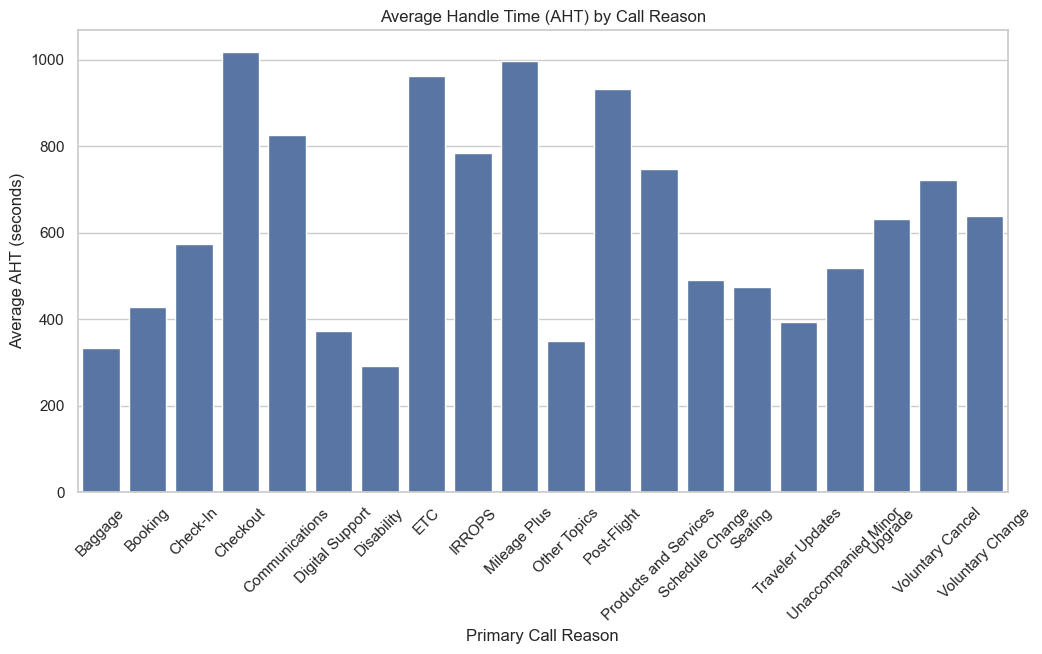

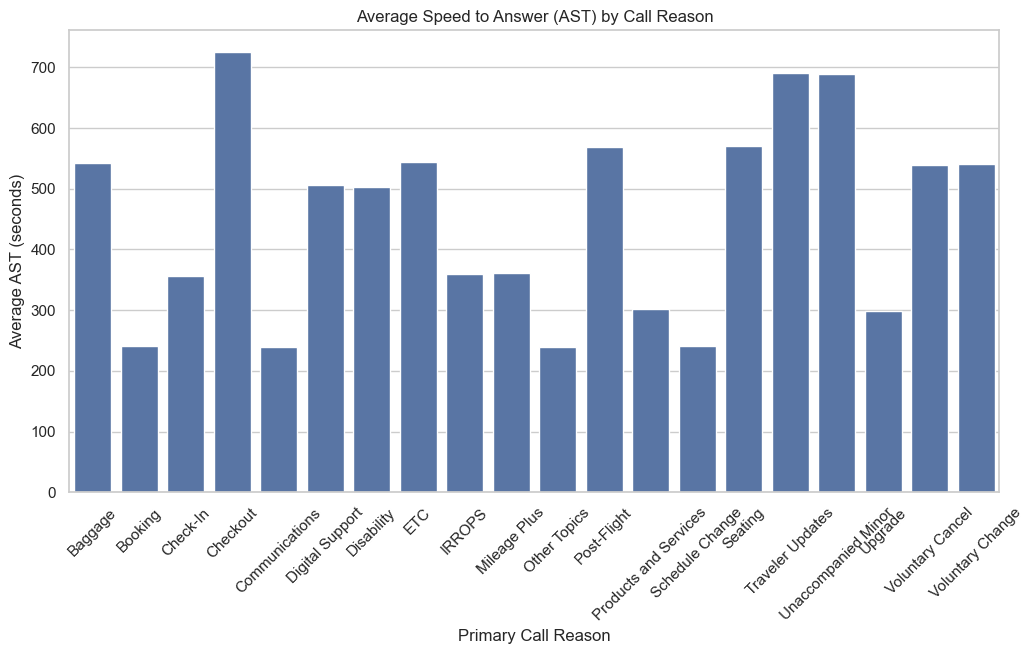

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(data=groupAvgReason, x='primary_call_reason', y='Avg_AHT_seconds')
plt.title('Average Handle Time (AHT) by Call Reason')
plt.xticks(rotation=45)
plt.xlabel('Primary Call Reason')
plt.ylabel('Average AHT (seconds)')
plt.show()


plt.figure(figsize=(12, 6))
sns.barplot(data=groupAvgReason, x='primary_call_reason', y='Avg_AST_seconds')
plt.title('Average Speed to Answer (AST) by Call Reason')
plt.xticks(rotation=45)
plt.xlabel('Primary Call Reason')
plt.ylabel('Average AST (seconds)')
plt.show()

In [10]:
agent_performance = merged_df.groupby('agent_id_x')['AHT_inSeconds'].mean().sort_values(ascending=False)
agent_tone_analysis = merged_df.groupby('agent_tone')['AHT_inSeconds'].mean().sort_values(ascending=False)

top_performers = agent_performance.tail(5)
print("Top performers (lowest AHT):\n", top_performers)


bottom_performers = agent_performance.head(5)
print("Bottom performers (highest AHT):\n", bottom_performers)

top_agents_call_types = merged_df[merged_df['agent_id_x'].isin(top_performers.index)].groupby('primary_call_reason')['AHT_inSeconds'].mean()
bottom_agents_call_types = merged_df[merged_df['agent_id_x'].isin(bottom_performers.index)].groupby('primary_call_reason')['AHT_inSeconds'].mean()

call_type_analysis = merged_df.groupby('primary_call_reason')['AHT_inSeconds'].mean().sort_values(ascending=False)
customer_tone_analysis = merged_df.groupby('customer_tone')['AHT_inSeconds'].mean().sort_values(ascending=False)

call_type_silence = merged_df.groupby('primary_call_reason').agg(
    avg_silence=('silence_percent_average', 'mean'),
    avg_AHT=('AHT_inSeconds', 'mean')
).sort_values(by='avg_AHT', ascending=False)



Top performers (lowest AHT):
 agent_id_x
676262    390.000000
229129    373.333333
161354    360.000000
616988    285.000000
547592    180.000000
Name: AHT_inSeconds, dtype: float64
Bottom performers (highest AHT):
 agent_id_x
102574    3600.0
506130    2880.0
255256    2620.0
140146    2620.0
558705    1980.0
Name: AHT_inSeconds, dtype: float64


C:\Users\Abhinav\AppData\Local\Temp\ipykernel_10424\1694043828.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  call_type_trend = call_type_trend.fillna(method='ffill').fillna(method='bfill')
C:\Users\Abhinav\AppData\Local\Temp\ipykernel_10424\1694043828.py:16: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(call_type_trend.index, call_type_trend[column], label=column)


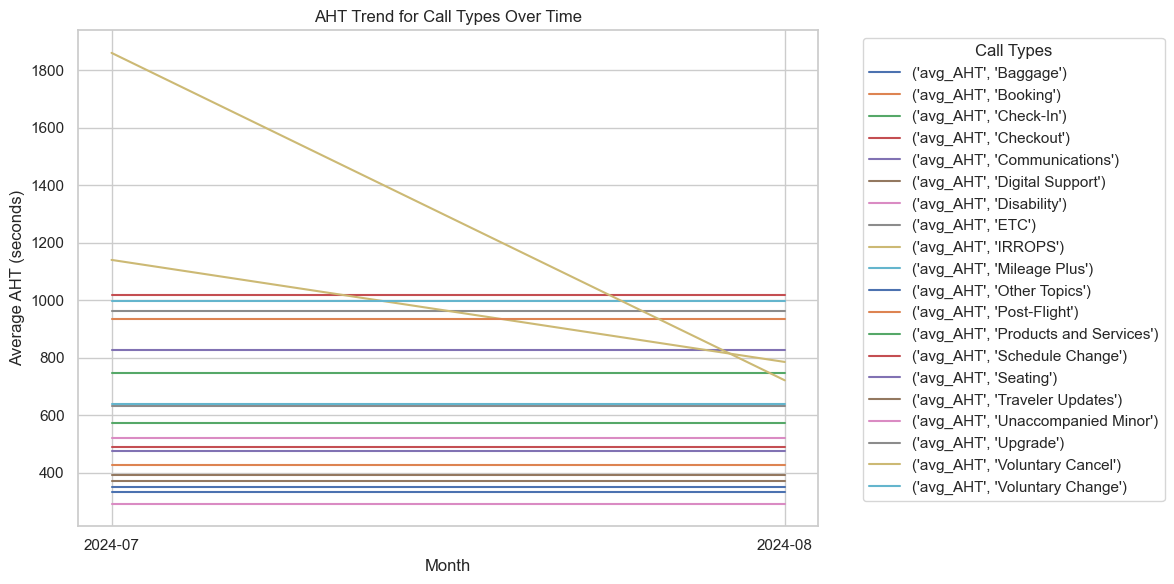

In [11]:
import matplotlib.pyplot as plt

merged_df['call_start_datetime'] = pd.to_datetime(merged_df['call_start_datetime'])

merged_df['year_month'] = merged_df['call_start_datetime'].dt.to_period('M')

call_type_trend = merged_df.groupby(['primary_call_reason', 'year_month']).agg(
    avg_AHT=('AHT_inSeconds', 'mean')
).unstack(level=0)
call_type_trend.index = call_type_trend.index.astype(str)

call_type_trend = call_type_trend.fillna(method='ffill').fillna(method='bfill')

plt.figure(figsize=(12, 6))
for column in call_type_trend.columns:
    plt.plot(call_type_trend.index, call_type_trend[column], label=column)

plt.title('AHT Trend for Call Types Over Time')
plt.xlabel('Month')
plt.ylabel('Average AHT (seconds)')
plt.legend(title='Call Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [12]:
sentiment_correlation = merged_df[['average_sentiment', 'AHT_inSeconds']].corr()
print(sentiment_correlation)

                   average_sentiment  AHT_inSeconds
average_sentiment           1.000000      -0.076065
AHT_inSeconds              -0.076065       1.000000


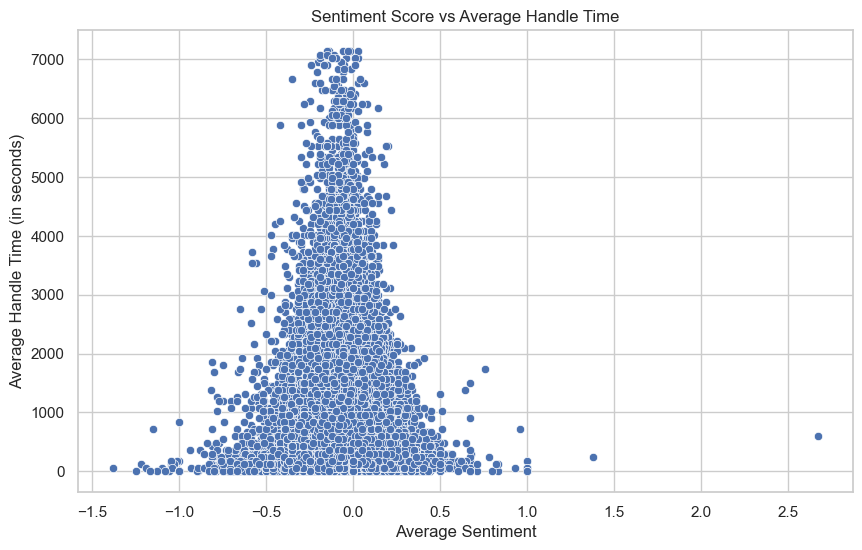

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='average_sentiment', y='AHT_inSeconds', data=merged_df)
plt.title('Sentiment Score vs Average Handle Time')
plt.xlabel('Average Sentiment')
plt.ylabel('Average Handle Time (in seconds)')
plt.show()

C:\Users\Abhinav\AppData\Local\Temp\ipykernel_10424\899007804.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_category_analysis = merged_df.groupby('sentiment_category')['AHT_inSeconds'].mean()


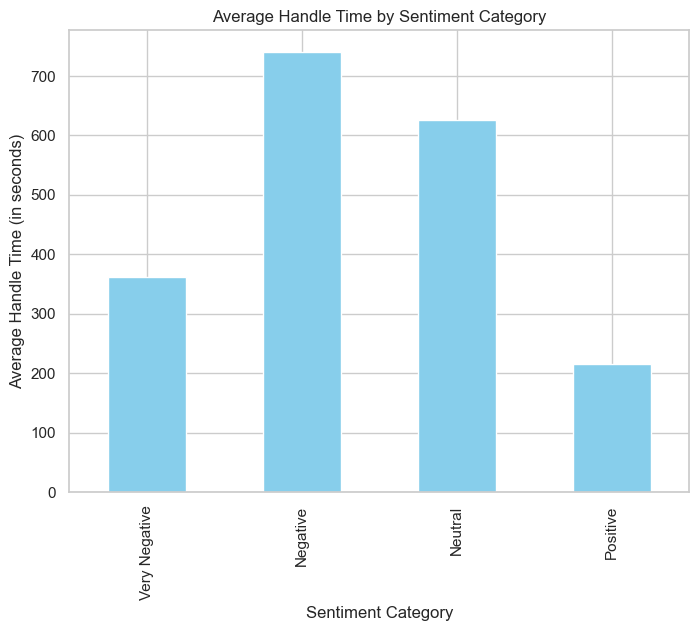

In [14]:
bins = [-1, -0.5, 0, 0.5, 1]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive']

merged_df['sentiment_category'] = pd.cut(merged_df['average_sentiment'], bins=bins, labels=labels)

sentiment_category_analysis = merged_df.groupby('sentiment_category')['AHT_inSeconds'].mean()

sentiment_category_analysis.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Average Handle Time by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Handle Time (in seconds)')
plt.show()

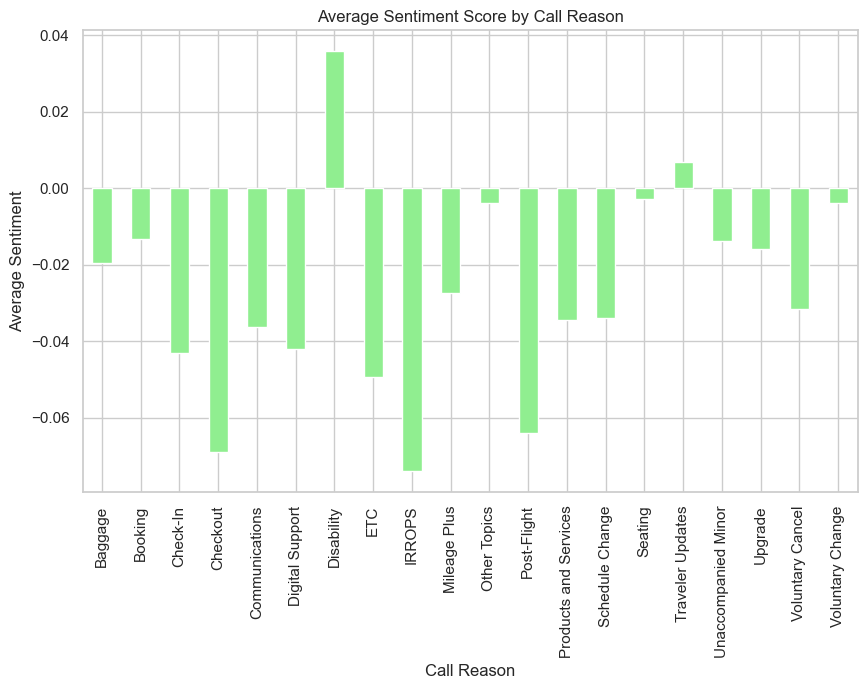

In [15]:
sentiment_by_reason = merged_df.groupby('primary_call_reason')['average_sentiment'].mean()

sentiment_by_reason.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Average Sentiment Score by Call Reason')
plt.xlabel('Call Reason')
plt.ylabel('Average Sentiment')
plt.show()

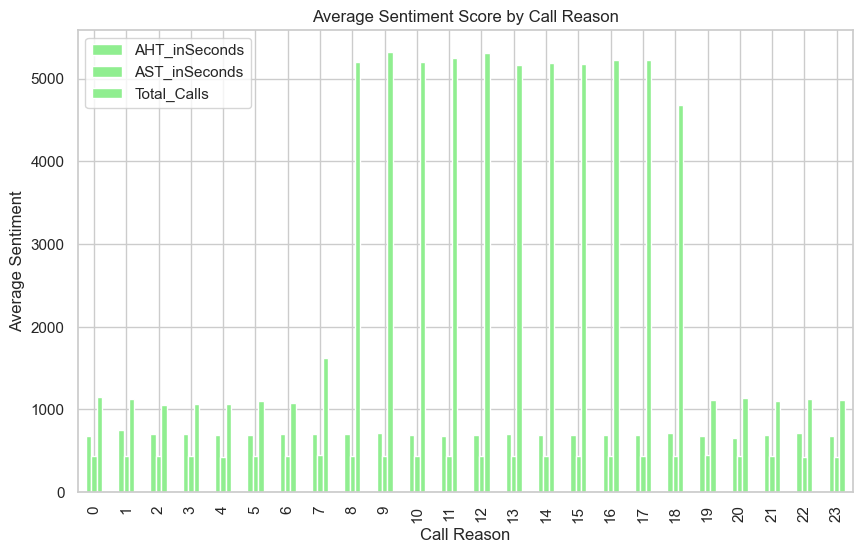

,silence_percent_average,AHT_inSeconds
primary_call_reason,,
IRROPS,0.309447,785.116069
Communications,0.303631,826.718750
Post-Flight,0.297752,932.896074
Checkout,0.292428,1016.853814
Voluntary Change,0.289654,639.153761


In [16]:
merged_df['call_start_datetime'] = pd.to_datetime(merged_df['call_start_datetime'])

merged_df['hour'] = merged_df['call_start_datetime'].dt.hour

high_volume_analysis = merged_df.groupby('hour')[['AHT_inSeconds', 'AST_inSeconds']].mean()

call_volume_by_hour = merged_df.groupby('hour')['call_id'].count()

high_volume_analysis['Total_Calls'] = call_volume_by_hour

high_volume_analysis.sort_values(by='Total_Calls', ascending=False)

high_volume_analysis.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Average Sentiment Score by Call Reason')
plt.xlabel('Call Reason')
plt.ylabel('Average Sentiment')
plt.show()

silence_correlation = merged_df[['silence_percent_average', 'AHT_inSeconds']].corr()

silence_analysis = merged_df.groupby('primary_call_reason')[['silence_percent_average', 'AHT_inSeconds']].mean()

silence_analysis = silence_analysis.sort_values(by='silence_percent_average', ascending=False)


silence_analysis.head()

In [17]:
elite_customer_analysis = merged_df.groupby('elite_level_code')[['AHT_inSeconds', 'AST_inSeconds']].mean()

call_volume_by_elite = merged_df.groupby('elite_level_code')['call_id'].count()

elite_customer_analysis['Total_Calls'] = call_volume_by_elite

elite_customer_analysis.sort_values(by='AHT_inSeconds', ascending=False).head()

,AHT_inSeconds,AST_inSeconds,Total_Calls
elite_level_code,,,
5.0,896.950608,411.410165,1397
4.0,788.244706,413.308235,2125
3.0,727.510460,429.341004,5736
2.0,726.449925,432.772795,8028
0.0,695.999166,438.579273,14387


In [18]:
silence_sentiment_analysis = merged_df.groupby(['customer_tone', 'agent_tone'])[['silence_percent_average', 'AHT_inSeconds', 'AST_inSeconds']].mean()

silence_sentiment_analysis = silence_sentiment_analysis.sort_values(by='AHT_inSeconds', ascending=False)

silence_sentiment_analysis.head()

,,silence_percent_average,AHT_inSeconds,AST_inSeconds
customer_tone,agent_tone,,,
neutral,neutral,0.290490,763.281432,433.943760
angry,neutral,0.284378,749.260331,433.265424
calm,neutral,0.284913,748.857309,436.752475
frustrated,neutral,0.285798,743.822904,434.252656
polite,neutral,0.284396,738.813915,434.064908


In [19]:
high_volume_sentiment_analysis = merged_df.groupby(['hour', 'customer_tone'])[['AHT_inSeconds', 'AST_inSeconds']].mean()

high_volume_sentiment_analysis = high_volume_sentiment_analysis.sort_values(by=['hour', 'AHT_inSeconds'], ascending=False)

high_volume_sentiment_analysis

AHT_inSeconds  AST_inSeconds
hour customer_tone                              
23   frustrated        737.004049     420.728745
     polite            731.214953     438.224299
     neutral           659.154930     435.211268
     calm              636.056338     420.281690
     angry             597.142857     428.311688
...                           ...            ...
0    angry             744.383562     430.684932
     frustrated        723.317972     439.354839
     polite            664.541833     440.318725
     neutral           644.810127     437.215190
     calm              642.511211     446.367713

[120 rows x 2 columns]

In [20]:
silence_correlation = merged_df[['silence_percent_average', 'AHT_inSeconds']].corr()

silence_analysis = merged_df.groupby('primary_call_reason')[['silence_percent_average', 'AHT_inSeconds']].mean()

silence_analysis = silence_analysis.sort_values(by='silence_percent_average', ascending=False)

silence_analysis.head()

,silence_percent_average,AHT_inSeconds
primary_call_reason,,
IRROPS,0.309447,785.116069
Communications,0.303631,826.718750
Post-Flight,0.297752,932.896074
Checkout,0.292428,1016.853814
Voluntary Change,0.289654,639.153761


In [21]:
elite_customer_analysis = merged_df.groupby('elite_level_code')[['AHT_inSeconds', 'AST_inSeconds']].mean()

call_volume_by_elite = merged_df.groupby('elite_level_code')['call_id'].count()

elite_customer_analysis['Total_Calls'] = call_volume_by_elite

elite_customer_analysis.sort_values(by='AHT_inSeconds', ascending=False).head()

,AHT_inSeconds,AST_inSeconds,Total_Calls
elite_level_code,,,
5.0,896.950608,411.410165,1397
4.0,788.244706,413.308235,2125
3.0,727.510460,429.341004,5736
2.0,726.449925,432.772795,8028
0.0,695.999166,438.579273,14387


In [22]:
silence_sentiment_analysis = merged_df.groupby(['customer_tone', 'agent_tone'])[['silence_percent_average', 'AHT_inSeconds', 'AST_inSeconds']].mean()

silence_sentiment_analysis = silence_sentiment_analysis.sort_values(by='AHT_inSeconds', ascending=False)

silence_sentiment_analysis.head()

,,silence_percent_average,AHT_inSeconds,AST_inSeconds
customer_tone,agent_tone,,,
neutral,neutral,0.290490,763.281432,433.943760
angry,neutral,0.284378,749.260331,433.265424
calm,neutral,0.284913,748.857309,436.752475
frustrated,neutral,0.285798,743.822904,434.252656
polite,neutral,0.284396,738.813915,434.064908


In [23]:
high_volume_sentiment_analysis = merged_df.groupby(['hour', 'customer_tone'])[['AHT_inSeconds', 'AST_inSeconds']].mean()

high_volume_sentiment_analysis = high_volume_sentiment_analysis.sort_values(by=['hour', 'AHT_inSeconds'], ascending=False)

high_volume_sentiment_analysis

AHT_inSeconds  AST_inSeconds
hour customer_tone                              
23   frustrated        737.004049     420.728745
     polite            731.214953     438.224299
     neutral           659.154930     435.211268
     calm              636.056338     420.281690
     angry             597.142857     428.311688
...                           ...            ...
0    angry             744.383562     430.684932
     frustrated        723.317972     439.354839
     polite            664.541833     440.318725
     neutral           644.810127     437.215190
     calm              642.511211     446.367713

[120 rows x 2 columns]

In [24]:
elite_sentiment_analysis = merged_df.groupby(['elite_level_code', 'customer_tone'])[['AHT_inSeconds', 'AST_inSeconds']].mean()

elite_sentiment_analysis = elite_sentiment_analysis.sort_values(by='AHT_inSeconds', ascending=False)

elite_sentiment_analysis

AHT_inSeconds  AST_inSeconds
elite_level_code customer_tone                              
5.0              calm              962.307692     414.545455
                 angry             914.210526     405.563910
                 frustrated        899.785714     413.357143
                 neutral           875.505618     408.089888
4.0              frustrated        866.080760     402.042755
                 calm              839.545455     412.727273
5.0              polite            838.783784     413.310811
4.0              neutral           766.281755     419.584296
3.0              polite            759.543058     422.530756
2.0              neutral           755.965418     429.129683
4.0              angry             745.918854     415.704057
2.0              angry             742.756005     431.453856
4.0              polite            731.578947     416.052632
3.0              neutral           728.549223     441.502591
                 angry             724.438776     425.969388
2.0              polite            716.848249     434.007782
0.0              neutral           715.350938     438.971508
3.0              calm              714.903678     432.031524
                 frustrated        712.950673     424.466368
2.0              calm              712.125480     441.049936
                 frustrated        703.537500     428.962500
0.0              calm              701.128699     434.927736
1.0              calm              695.438475     436.949740
0.0              polite            695.170279     435.768834
1.0              polite            694.106346     438.421955
                 frustrated        691.196641     432.197341
NaN              neutral           687.550421     442.193068
1.0              angry             687.130802     439.493671
0.0              angry             686.497354     441.291005
                 frustrated        682.632322     441.700776
1.0              neutral           674.968421     437.873684
NaN              angry             670.322826     439.175845
                 calm              669.586006     443.486880
                 frustrated        666.335549     445.823230
                 polite            648.842147     442.716729

In [25]:
correlation_columns = ['AHT_inSeconds', 'AST_inSeconds', 'silence_percent_average', 'average_sentiment', 'elite_level_code']

correlation_matrix = merged_df[correlation_columns].corr()

correlation_matrix

,AHT_inSeconds,AST_inSeconds,silence_percent_average,average_sentiment,elite_level_code
AHT_inSeconds,1.000000,-0.027778,0.407040,-0.076065,0.042030
AST_inSeconds,-0.027778,1.000000,-0.012200,0.039881,-0.042461
silence_percent_average,0.407040,-0.012200,1.000000,0.035339,-0.005605
average_sentiment,-0.076065,0.039881,0.035339,1.000000,0.001741
elite_level_code,0.042030,-0.042461,-0.005605,0.001741,1.000000


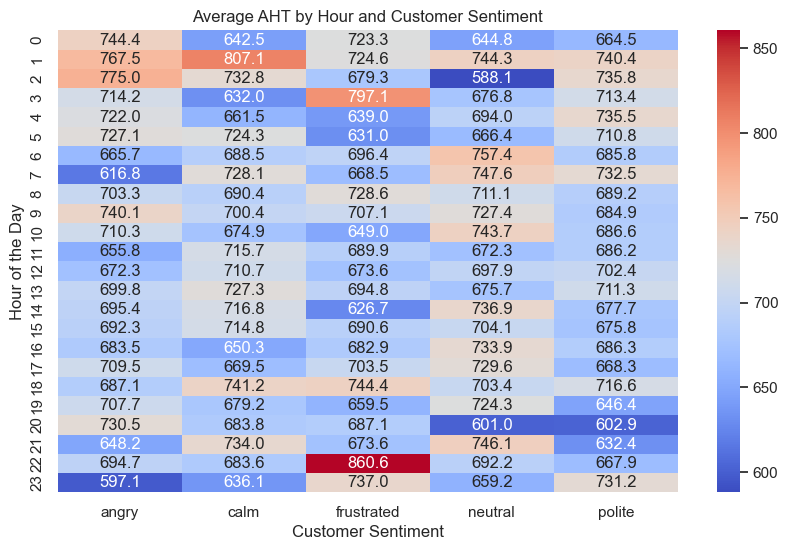

In [26]:
pivot_data = merged_df.groupby(['hour', 'customer_tone'])['AHT_inSeconds'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Average AHT by Hour and Customer Sentiment')
plt.ylabel('Hour of the Day')
plt.xlabel('Customer Sentiment')
plt.show()